In [1]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.utils import train_fn
from astra.torch.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = "cuda"

In [2]:
path = "/home/vannsh.jani/brick_kilns/ssl_exp/data"
x_train = torch.load(join(path, "ban_x_train.pt"))
y_train = torch.load(join(path, "ban_y_train.pt"))
x_test = torch.load(join(path, "ban_x_test.pt"))
y_test = torch.load(join(path, "ban_y_test.pt"))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_b = torch.cat([x_train, x_test], dim=0).to(device)
y_b = torch.cat([y_train, y_test], dim=0).to(device)

print(x_b.shape, y_b.shape)

torch.Size([19124, 3, 224, 224]) torch.Size([19124]) torch.Size([6375, 3, 224, 224]) torch.Size([6375])
torch.Size([25499, 3, 224, 224]) torch.Size([25499])


In [3]:
x_d = torch.load(join(path, "delhi_test_images_50.pt")).to(device)
y_d = torch.load(join(path, "delhi_test_labels_50.pt")).to(device)
print(x_d.shape, y_d.shape)

torch.Size([5013, 3, 224, 224]) torch.Size([5013])


In [4]:
# Downstream model
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        eff = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.eff = nn.Sequential(*list(eff.children())[:-1])
        for child in self.eff[0][1:4]:
            child.requires_grad = False
        self.last_layer = list(eff.children())[-1]
        # self.eff.load_state_dict(torch.load("/home/vannsh.jani/brick_kilns/ssl_exp/byol/byol_bd_150.pth")) # load different weights
        self.last_layer[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.eff(x).squeeze(-2, -1)
        # print(x.shape)
        x = self.last_layer(x)
        return x

In [5]:
model = DownstreamModel(2).to(device)
model(torch.rand(2, 3, 224, 224).to(device)).shape

torch.Size([2, 2])

In [7]:
lr = 1e-4
epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(epochs):
    print("Epoch:", epoch)
    model.train()
    iter_losses, epoch_losses = train_fn(model, loss_fn, x_b, y_b, lr=lr, epochs=1, batch_size=64)
    
    model.eval()
    
    with torch.no_grad():
        local_losses = []
        for i in range(0, len(x_b), 64):
            y_pred = model(x_b[i:i+64])
            loss = loss_fn(y_pred, y_b[i:i+64].long())
            local_losses.append(loss.item())

        train_losses.append(sum(local_losses)/len(local_losses))
    
    with torch.no_grad():
        y_pred = model(x_d)
        test_loss = loss_fn(y_pred, y_d.long())
        test_losses.append(test_loss.item())
        y_pred = torch.argmax(y_pred, dim=1)
        print("Accuracy:", accuracy_score(y_d, y_pred))
        print("Precision:", precision_score(y_d, y_pred))
        print("Recall:", recall_score(y_d, y_pred))
        print("F1 Score:", f1_score(y_d, y_pred))
        print("Train Loss:", train_losses[-1])
        print("Test Loss:", test_losses[-1])
        
    torch.cuda.empty_cache()

Epoch: 0


Loss: 0.00292690: 100%|██████████| 1/1 [00:24<00:00, 24.50s/it]


Accuracy: tensor(0.9611, device='cuda:0')
Precision: tensor(0.6929, device='cuda:0')
Recall: tensor(0.9116, device='cuda:0')
F1 Score: tensor(0.7874, device='cuda:0')
Train Loss: 0.0011869554731538529
Test Loss: 0.3061353862285614
Epoch: 1


Loss: 0.00387883: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9623, device='cuda:0')
Precision: tensor(0.7370, device='cuda:0')
Recall: tensor(0.8807, device='cuda:0')
F1 Score: tensor(0.8025, device='cuda:0')
Train Loss: 0.0009380111412817147
Test Loss: 0.2572093605995178
Epoch: 2


Loss: 0.00247193: 100%|██████████| 1/1 [00:24<00:00, 24.46s/it]


Accuracy: tensor(0.9623, device='cuda:0')
Precision: tensor(0.7370, device='cuda:0')
Recall: tensor(0.8807, device='cuda:0')
F1 Score: tensor(0.8025, device='cuda:0')
Train Loss: 0.00048268879600583004
Test Loss: 0.2356705367565155
Epoch: 3


Loss: 0.00280897: 100%|██████████| 1/1 [00:24<00:00, 24.48s/it]


Accuracy: tensor(0.9555, device='cuda:0')
Precision: tensor(0.6296, device='cuda:0')
Recall: tensor(0.9162, device='cuda:0')
F1 Score: tensor(0.7463, device='cuda:0')
Train Loss: 0.002339795667855438
Test Loss: 0.351779043674469
Epoch: 4


Loss: 0.00299373: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9621, device='cuda:0')
Precision: tensor(0.7466, device='cuda:0')
Recall: tensor(0.8702, device='cuda:0')
F1 Score: tensor(0.8037, device='cuda:0')
Train Loss: 0.0008421724114993369
Test Loss: 0.23245655000209808
Epoch: 5


Loss: 0.00232611: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9561, device='cuda:0')
Precision: tensor(0.6545, device='cuda:0')
Recall: tensor(0.8950, device='cuda:0')
F1 Score: tensor(0.7561, device='cuda:0')
Train Loss: 0.0003591555414732789
Test Loss: 0.35203197598457336
Epoch: 6


Loss: 0.00118370: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9497, device='cuda:0')
Precision: tensor(0.5509, device='cuda:0')
Recall: tensor(0.9410, device='cuda:0')
F1 Score: tensor(0.6949, device='cuda:0')
Train Loss: 0.00030057917093820254
Test Loss: 0.4671361744403839
Epoch: 7


Loss: 0.00164763: 100%|██████████| 1/1 [00:24<00:00, 24.49s/it]


Accuracy: tensor(0.9479, device='cuda:0')
Precision: tensor(0.5662, device='cuda:0')
Recall: tensor(0.8939, device='cuda:0')
F1 Score: tensor(0.6933, device='cuda:0')
Train Loss: 0.003604028758658251
Test Loss: 0.48156973719596863
Epoch: 8


Loss: 0.00194889: 100%|██████████| 1/1 [00:24<00:00, 24.50s/it]


Accuracy: tensor(0.9567, device='cuda:0')
Precision: tensor(0.6775, device='cuda:0')
Recall: tensor(0.8781, device='cuda:0')
F1 Score: tensor(0.7649, device='cuda:0')
Train Loss: 0.0003457931230712246
Test Loss: 0.3870271146297455
Epoch: 9


Loss: 0.00148109: 100%|██████████| 1/1 [00:24<00:00, 24.49s/it]


Accuracy: tensor(0.9575, device='cuda:0')
Precision: tensor(0.6564, device='cuda:0')
Recall: tensor(0.9096, device='cuda:0')
F1 Score: tensor(0.7625, device='cuda:0')
Train Loss: 0.0006068482320810357
Test Loss: 0.41949719190597534


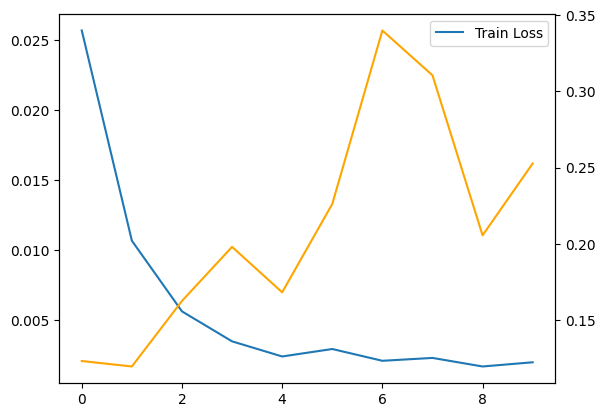

In [7]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.gca().twinx().plot(test_losses, label="Test Loss", color="orange")
# torch.save(model.state_dict(), "byol_lr4_ep50.pth")

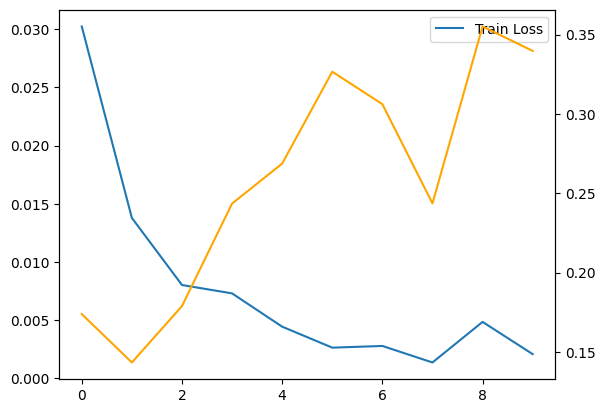